In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

import numpy as np
from matplotlib import pyplot as plt

import os
from PIL import Image
from skimage.util.shape import view_as_blocks
from math import sqrt

Using TensorFlow backend.


In [3]:
# block (16, 16, 15, 26, 3) is a numpy array stores 16 x 16 patches of 15 x 26 frame
# merge_block returns a 240 x 416 image
def merge_block(block):
    image_shape = (block.shape[0]*block.shape[2], block.shape[1]*block.shape[3], block.shape[4])
    img = np.empty(image_shape, dtype = np.float32)
    for i in range(16):
        for j in range(15):
            img[i*15 + j] = block[i][:,j].reshape((1, image_shape[1], 3))
            
    return img

In [4]:
# patch_shape = (15, 26, 3)
# return (76800, 15, 26, 3) patch_data; 76800 patches
def load_data(data_path, patch_shape):
    file_names = os.listdir(data_path)
    n_image = len(file_names)

#     image_shape = (240, 416, 3)
    input_im = np.array(Image.open(data1_path + '/' + file_names[0]))
    image_shape = input_im[...,:3].shape

    block_shape = (image_shape[0]//patch_shape[0], image_shape[1]//patch_shape[1])

    n_patch = block_shape[0] * block_shape[1]

    patch_data = np.empty((n_patch * n_image, patch_shape[0], patch_shape[1], patch_shape[2]), dtype = np.int32)
    
    for i in range(n_image):  
        input_im =  np.array(Image.open(data1_path + '/' + file_names[i]))
        block = view_as_blocks(input_im[...,:3], block_shape = patch_shape).reshape \
            ((n_patch, patch_shape[0], patch_shape[1], patch_shape[2]))
    #     print(block.shape)

        for j in range(n_patch):
            patch_data[i*n_patch + j] = block[j]
    patch_data = patch_data/255.
    train_num = patch_data.shape[0] * 3//4
    train_data = patch_data[:train_num]
    test_data = patch_data[train_num:]

    return (train_data,test_data)

In [5]:
# The image is actually 240 x 416, 
#     so we will have 16 x 16 patches with frame shape of 15 x 26 instead of 26 x 15
data1_path = 'RaceHorses_416x240_30'
patch_shape = (15, 26, 3)

train_data,test_data = load_data(data1_path, patch_shape)
train_data.shape

(57600, 15, 26, 3)

In [6]:
x=train_data.shape[1]
y=train_data.shape[2]
z=train_data.shape[3]

input_img = Input(shape=(x,y,z))

e = Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
e = MaxPooling2D((3, 2), padding='same')(e)
e = Conv2D(32, (5, 5), activation='relu', padding='same')(e)
#e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(16, (1, 1), activation='relu', padding='same')(e)
e = Conv2D(8, (3, 3), activation='relu', padding='same')(e)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(e)

d = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
d = Conv2D(8, (3, 3), activation='relu', padding='same')(d)
d = Conv2D(16, (1, 1), activation='relu', padding='same')(d)
#d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (5, 5), activation='relu', padding='same')(d)
d = UpSampling2D((3, 2))(d)
d = Conv2D(64, (7, 7), activation='relu', padding='same')(d)
decoded = Conv2D(3, (1, 1), activation='linear')(d)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(train_data,train_data, epochs=10, batch_size=25)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15, 26, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 26, 64)        9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 13, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 13, 32)         51232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 13, 16)         528       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 13, 8)          1160      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 13, 4)          292 

In [7]:
decoded_patches = autoencoder.predict(test_data)

In [8]:
decoded_patches.shape

(19200, 15, 26, 3)

In [9]:
test_img = decoded_patches[:256]
test_img = test_img.reshape(16,16,15,26,3)
test_img.shape

(16, 16, 15, 26, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


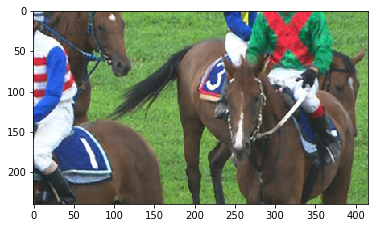

In [10]:
test_img = merge_block(test_img)
plt.imshow(test_img)